In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%cd /content/drive/My Drive/teaching/ai/student_projects/Michael_Ladyzhensky

%cd /content/drive/My Drive/AIPaper
!ls data2

/content/drive/My Drive/AIPaper
lp1.data  lp2.data  lp3.data  lp4.data	lp5.data


In [143]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
from   sklearn.model_selection import train_test_split
from   sklearn.preprocessing import StandardScaler
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from   sklearn.linear_model import LogisticRegression
from   sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

# Set options to display all columns
pd.set_option('display.max_columns', None)

In [4]:
dir_data = os.path.join(os.getcwd(), 'data2')

path_data_lp1 = os.path.join(dir_data, 'lp1.data')
path_data_lp2 = os.path.join(dir_data, 'lp2.data')
path_data_lp3 = os.path.join(dir_data, 'lp3.data')
path_data_lp4 = os.path.join(dir_data, 'lp4.data')
path_data_lp5 = os.path.join(dir_data, 'lp5.data')

In [5]:
def read_data_with_class_labels(filepath):
    records = []
    current_class = None
    sample_counter = -1  # will increment to 0 on first header
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # skip empty lines
            tokens = line.split()
            try:
                # try converting the first token to a float.
                # ff it succeeds, we assume the line is a numeric row.
                float(tokens[0])
                #convert the entire row to floats.
                data = list(map(float, tokens))
                #append the data along with the current class and sample number.
                records.append(data + [current_class, sample_counter])
            except ValueError:
                #if conversion fails, this line is a header with the class label.
                current_class = line
                sample_counter += 1
    df = pd.DataFrame(records, columns=['fx', 'fy', 'fz', 'tx', 'ty', 'tz', 'class_label', 'sample_num'])
    return df


In [6]:
df1 = read_data_with_class_labels(path_data_lp1)
df2 = read_data_with_class_labels(path_data_lp2)
df3 = read_data_with_class_labels(path_data_lp3)
df4 = read_data_with_class_labels(path_data_lp4)
df5 = read_data_with_class_labels(path_data_lp5)

df_data = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)


In [ ]:
'''
# assign labels to each dataframe
lst_df = [df1, df2, df3, df4, df5]
for i, df in enumerate(lst_df):
  df['label'] = i+1

# join the dataframes together
df_data = pd.concat(lst_df).reset_index(drop=True)

# assign sample numbers to every 15 rows
n_row = 15
df_data['sample_num'] = np.arange(len (df_data)) // n_row

df_data = df_data.rename(columns={'column_a': 'fx',
                                  'column_b': 'fy',
                                  'column_c': 'fz',
                                  'column_d': 'tx',
                                  'column_e': 'ty',
                                  'column_f': 'tz'})
'''

In [7]:

dir_data = os.path.join(os.getcwd(), 'data2')

feature_columns = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']
lst_feat_vecs = []

# group by sample number and flatten the feature columns
for sample_num, group in df_data.groupby('sample_num'):
    feature_vector = group[feature_columns].values.flatten()
    lst_feat_vecs.append(feature_vector)

#create a feature matrix DataFrame
df_features = pd.DataFrame(lst_feat_vecs)

#assign each sample its corresponding class label (from the header)
df_features['label'] = df_data.groupby('sample_num')['class_label'].first().values

#reset the index
df_features = df_features.reset_index(drop=True)


In [8]:
#RAW DATA
feature_columns = [col for col in df_data.columns if col not in ['sample_num', 'class_label']]

lst_feat_vecs = []

#group by sample_num, flatten each group into a single row
for sample_id, group in df_data.groupby('sample_num'):
    feature_vector = group[feature_columns].values.flatten()
    lst_feat_vecs.append(feature_vector)

df_features = pd.DataFrame(lst_feat_vecs)

#assign each sample's class label (e.g. "normal", "collision", etc.)
df_features['class_label'] = df_data.groupby('sample_num')['class_label'].first().values

# reset the index
df_features = df_features.reset_index(drop=True)

print(df_features.shape)
df_features.head()


(164, 451)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,class_label
0,-1.0,-1.0,63.0,-3.0,-1.0,0.0,0.0,0.0,62.0,-3.0,-1.0,0.0,-1.0,-1.0,61.0,-3.0,0.0,0.0,-1.0,-1.0,63.0,-2.0,-1.0,0.0,-1.0,-1.0,63.0,-3.0,-1.0,0.0,-1.0,-1.0,63.0,-3.0,-1.0,0.0,-1.0,-1.0,63.0,-3.0,0.0,0.0,-1.0,-1.0,63.0,-3.0,-1.0,0.0,-1.0,-1.0,63.0,-3.0,-1.0,0.0,-1.0,-1.0,61.0,-3.0,0.0,0.0,-1.0,-1.0,61.0,-3.0,0.0,0.0,-1.0,-1.0,64.0,-3.0,-1.0,0.0,-1.0,-1.0,64.0,-3.0,-1.0,0.0,-1.0,-1.0,60.0,-3.0,0.0,0.0,-1.0,0.0,64.0,-2.0,-1.0,0.0,-2.0,-1.0,81.0,0.0,-5.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,80.0,0.0,-4.0,0.0,-3.0,-1.0,79.0,1.0,-5.0,1.0,-2.0,-1.0,81.0,0.0,-5.0,0.0,-2.0,-1.0,80.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,80.0,1.0,-4.0,0.0,-1.0,-1.0,80.0,0.0,-4.0,1.0,-2.0,-1.0,78.0,0.0,-5.0,0.0,-3.0,-1.0,80.0,1.0,-4.0,1.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,81.0,0.0,-5.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,80.0,0.0,-4.0,0.0,-3.0,-1.0,79.0,1.0,-5.0,1.0,-2.0,-1.0,81.0,0.0,-5.0,0.0,-2.0,-1.0,80.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,80.0,1.0,-4.0,0.0,-1.0,-1.0,80.0,0.0,-4.0,1.0,-2.0,-1.0,78.0,0.0,-5.0,0.0,-3.0,-1.0,80.0,1.0,-4.0,1.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,2.0,20.0,5.0,-6.0,-1.0,-2.0,1.0,20.0,5.0,-6.0,0.0,-2.0,1.0,23.0,5.0,-6.0,0.0,-2.0,2.0,20.0,5.0,-6.0,-1.0,-3.0,1.0,22.0,5.0,-6.0,-1.0,-2.0,2.0,20.0,5.0,-6.0,-1.0,-2.0,2.0,20.0,5.0,-6.0,-1.0,-3.0,3.0,20.0,5.0,-6.0,-1.0,-2.0,1.0,13.0,7.0,-3.0,-1.0,-3.0,1.0,4.0,3.0,-7.0,0.0,-1.0,0.0,13.0,4.0,-5.0,-1.0,-4.0,3.0,15.0,2.0,-11.0,-1.0,-1.0,2.0,29.0,7.0,-6.0,-1.0,1.0,-1.0,23.0,9.0,2.0,0.0,-2.0,2.0,29.0,3.0,-6.0,0.0,-2.0,-1.0,81.0,0.0,-5.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,80.0,0.0,-4.0,0.0,-3.0,-1.0,79.0,1.0,-5.0,1.0,-2.0,-1.0,81.0,0.0,-5.0,0.0,-2.0,-1.0,80.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,-2.0,-1.0,80.0,1.0,-4.0,0.0,-1.0,-1.0,80.0,0.0,-4.0,1.0,-2.0,-1.0,78.0,0.0,-5.0,0.0,-3.0,-1.0,80.0,1.0,-4.0,1.0,-2.0,-1.0,79.0,0.0,-4.0,0.0,normal
1,-1.0,-1.0,63.0,-2.0,-1.0,0.0,-1.0,-1.0,63.0,-3.0,-1.0,0.0,-1.0,-1.0,61.0,-3.0,0.0,0.0,0.0,-4.0,63.0,1.0,0.0,0.0,0.0,-1.0,59.0,-2.0,0.0,-1.0,-3.0,3.0,57.0,-8.0,-3.0,-1.0,-1.0,3.0,70.0,-1

In [9]:
# look at class distribution
df_features.rename(columns={'class_label': 'label'}, inplace=True)

# Check distribution of labels
print( round(df_features['label'].value_counts() / len(df_features['label']), 2) )
# class distribution has some imbalance

label
collision             0.27
obstruction           0.21
normal                0.13
bottom_collision      0.12
fr_collision          0.10
collision_in_part     0.07
bottom_obstruction    0.06
collision_in_tool     0.03
Name: count, dtype: float64


In [10]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
numeric_cols = df_features.columns.difference(['label'])
df_features[numeric_cols] = imputer.fit_transform(df_features[numeric_cols])


In [11]:
#calculate the percentage of nulls in each column
null_percentages = df_features.isnull().sum() / df_features.shape[0] * 100

df_features.isnull().sum().any()

False

In [12]:
# figure out which are categorical vs. numerical columns
cols_cat = [col for col in df_features.columns if df_features[col].dtype == 'object']
cols_num = [col for col in df_features.columns if col not in cols_cat]

assert (len(cols_cat) + len(cols_num) == df_features.shape[1])

print(f'# of categorical columns: {len(cols_cat)}')

# of categorical columns: 1


In [13]:
cols_feat  = [x for x in df_features.columns if x != 'label']
cols_label = 'label'

assert len(cols_feat) + 1 == df_features.shape[1]

X = df_features[cols_feat]
y = df_features[cols_label]


In [14]:
scaler = StandardScaler()

#transform the data using the fitted scaler
X_scaled = scaler.fit_transform(X)

X_scaled

array([[ 4.26821259e-02, -2.91303605e-01,  5.44467974e-01, ...,
         1.21558713e+00,  2.64940665e+00,  1.92444245e+00],
       [ 4.26821259e-02, -2.91303605e-01,  5.44467974e-01, ...,
         7.69238732e-01,  9.46540152e-01,  3.70493055e+00],
       [ 4.26821259e-02, -2.62030449e-01,  5.15956639e-01, ...,
         3.59611193e+00,  5.20823529e-01,  1.56834483e+00],
       ...,
       [-2.21011556e-01,  2.35613210e-01,  2.59354629e-01, ...,
         0.00000000e+00,  0.00000000e+00,  3.16278221e-16],
       [-9.16203991e-01,  3.52705836e-01,  2.21339516e-01, ...,
         0.00000000e+00,  0.00000000e+00,  3.16278221e-16],
       [ 2.82403655e-01, -5.54762013e-01,  1.92828182e-01, ...,
         0.00000000e+00,  0.00000000e+00,  3.16278221e-16]])

In [15]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42, stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)


In [19]:
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(X_train, y_train)

predictions       = logistic_model.predict(X_test)
predictions_proba = logistic_model.predict_proba(X_test)# proba for 1/positive class

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

  bottom_collision       1.00      1.00      1.00         4
bottom_obstruction       1.00      1.00      1.00         2
         collision       0.69      1.00      0.82         9
 collision_in_part       0.75      1.00      0.86         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       0.75      1.00      0.86         3
            normal       1.00      0.75      0.86         4
       obstruction       1.00      0.43      0.60         7

          accuracy                           0.82        33
         macro avg       0.77      0.77      0.75        33
      weighted avg       0.84      0.82      0.79        33



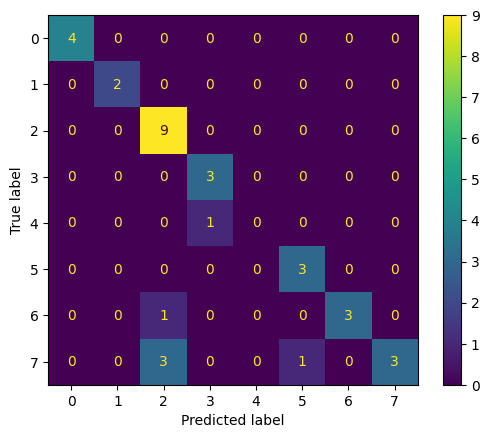

In [59]:
#Logistic Regression (RAW)
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

[[4 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 8 0 0 0 1 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 2 0 1]
 [0 0 1 0 0 0 3 0]
 [0 0 1 0 0 1 0 5]]


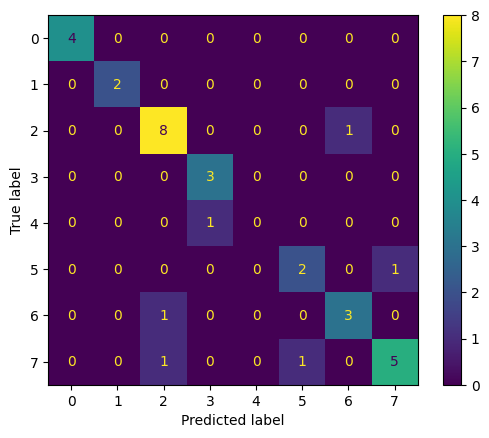

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       0.80      0.89      0.84         9
           3       0.75      1.00      0.86         3
           4       0.00      0.00      0.00         1
           5       0.67      0.67      0.67         3
           6       0.75      0.75      0.75         4
           7       0.83      0.71      0.77         7

    accuracy                           0.82        33
   macro avg       0.72      0.75      0.74        33
weighted avg       0.80      0.82      0.80        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
#XGBOOST(RAW)
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# fit on y_train and transform
y_train_encoded = encoder.fit_transform(y_train)

# just transform
y_test_encoded = encoder.transform(y_test)

# creates XGBoost model
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=5,  # I think I have 5 classes
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train_encoded)

# use the trained model to make predictions on the data
predictions_xgb = xgb_model.predict(X_test)
predictions_proba_xgb = xgb_model.predict_proba(X_test)

print(confusion_matrix(y_test_encoded, predictions_xgb))
ConfusionMatrixDisplay.from_predictions(y_test_encoded, predictions_xgb)
plt.show()

print(classification_report(y_test_encoded, predictions_xgb))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

  bottom_collision       0.40      0.50      0.44         4
bottom_obstruction       1.00      1.00      1.00         2
         collision       0.60      0.67      0.63         9
 collision_in_part       0.67      0.67      0.67         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       1.00      0.67      0.80         3
            normal       1.00      1.00      1.00         4
       obstruction       1.00      1.00      1.00         7

          accuracy                           0.76        33
         macro avg       0.71      0.69      0.69        33
      weighted avg       0.76      0.76      0.75        33



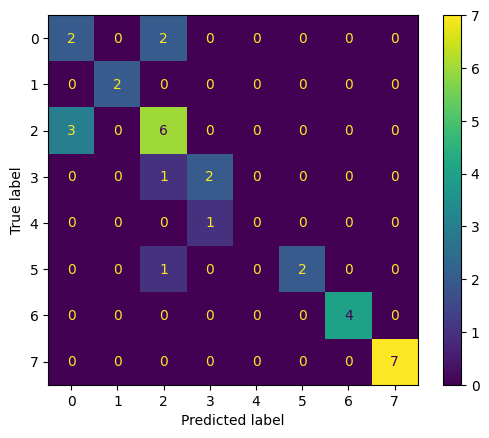

In [133]:
#RANDOM FOREST CLASSIFER (RAW)
#trains forest classifer model using data
clf = RandomForestClassifier(class_weight="balanced", random_state=42).fit(X_train, y_train)

# makes predictions
predictions = clf.predict(X_test)

# prediction probabilities
predictions_proba = clf.predict_proba(X_test)

print(classification_report(y_test, predictions))


cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

  bottom_collision       0.29      0.50      0.36         4
bottom_obstruction       1.00      1.00      1.00         2
         collision       0.67      0.67      0.67         9
 collision_in_part       0.50      0.33      0.40         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       0.67      0.67      0.67         3
            normal       1.00      1.00      1.00         4
       obstruction       0.83      0.71      0.77         7

          accuracy                           0.67        33
         macro avg       0.62      0.61      0.61        33
      weighted avg       0.68      0.67      0.67        33

Accuracy: 0.6666666666666666


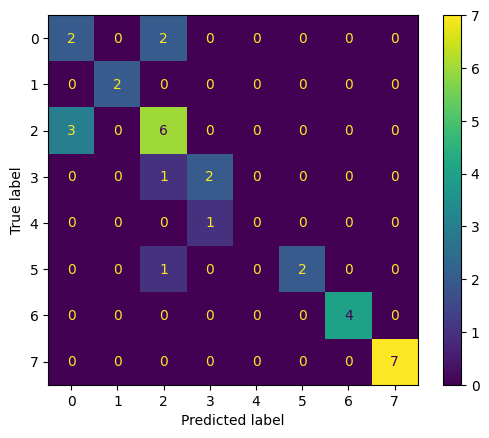

In [145]:
#Decision Tree
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# prediction probabilities
predictions_proba = clf.predict_proba(X_test)

print(classification_report(y_test, y_pred))

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [23]:
#FORCES AND TORQUES

# df_data is organized in the following way:
# every 15 rows is a sample, reprenting 15s worth of data
# each row is a time sample
# there are 6 columns, each column is a torque/force feature

df_features_s2 = pd.DataFrame()

df_features_s2[['fx', 'fy', 'fz']] = df_data[['fx', 'fy', 'fz']]

df_features_s2['fxy']  = (df_data['fx']**2 + df_data['fy']**2)**0.5
df_features_s2['fxz']  = (df_data['fx']**2 + df_data['fz']**2)**0.5
df_features_s2['fyz']  = (df_data['fy']**2 + df_data['fz']**2)**0.5
df_features_s2['fxyz'] = (df_data['fx']**2 + df_data['fy']**2 + df_data['fz']**2)**0.5

df_features_s2[['tx', 'ty', 'tz']] = df_data[['tx', 'ty', 'tz']]

df_features_s2['txy']  = (df_data['tx']**2 + df_data['ty']**2)**0.5
df_features_s2['txz']  = (df_data['tx']**2 + df_data['tz']**2)**0.5
df_features_s2['tyz']  = (df_data['ty']**2 + df_data['tz']**2)**0.5
df_features_s2['txyz'] = (df_data['tx']**2 + df_data['ty']**2 + df_data['tz']**2)**0.5

df_features_s2[['class_label', 'sample_num']] = df_data[['class_label', 'sample_num']]

df_features_s2.head()


# next step:
# get into the format of 463 x 211
# train 3 models using this dataset


,fx,fy,fz,fxy,fxz,fyz,fxyz,tx,ty,tz,txy,txz,tyz,txyz,class_label,sample_num
0,-1.0,-1.0,63.0,1.414214,63.007936,63.007936,63.015871,-3.0,-1.0,0.0,3.162278,3.0,1.0,3.162278,normal,0
1,0.0,0.0,62.0,0.000000,62.000000,62.000000,62.000000,-3.0,-1.0,0.0,3.162278,3.0,1.0,3.162278,normal,0
2,-1.0,-1.0,61.0,1.414214,61.008196,61.008196,61.016391,-3.0,0.0,0.0,3.000000,3.0,0.0,3.000000,normal,0
3,-1.0,-1.0,63.0,1.414214,63.007936,63.007936,63.015871,-2.0,-1.0,0.0,2.236068,2.0,1.0,2.236068,normal,0
4,-1.0,-1.0,63.0,1.414214,63.007936,63.007936,63.015871,-3.0,-1.0,0.0,3.162278,3.0,1.0,3.162278,normal,0


In [24]:
print(round(df_features_s2['class_label'].value_counts() / len(df_features_s2['class_label']), 2))

class_label
normal                0.24
collision             0.19
obstruction           0.12
collision_in_part     0.10
collision_in_tool     0.06
bottom_collision      0.06
bottom_obstruction    0.05
ok                    0.04
fr_collision          0.03
moved                 0.03
left_col              0.02
slightly_moved        0.02
back_col              0.02
front_col             0.01
right_col             0.01
lost                  0.01
Name: count, dtype: float64


In [25]:
feature_columns_s2 = [
    col for col in df_features_s2.columns
    if col not in ['sample_num', 'class_label']
]

lst_feat_vecs_s2 = []

#flatten the selected columns into one vector per each sample num
for sample_num, group in df_features_s2.groupby('sample_num'):
    feature_vector = group[feature_columns_s2].values.flatten()
    lst_feat_vecs_s2.append(feature_vector)

df_features_s2_agg = pd.DataFrame(lst_feat_vecs_s2)

#attach the label
df_features_s2_agg['label'] = (
    df_features_s2.groupby('sample_num')['class_label'].first().values
)

df_features_s2_agg = df_features_s2_agg.reset_index(drop=True)

print(df_features_s2_agg.shape)
df_features_s2_agg.head()

cols_feat_s2  = [x for x in df_features_s2_agg.columns if x != 'label']
cols_label_s2 = 'label'

X_s2 = df_features_s2_agg[cols_feat_s2]
y_s2 = df_features_s2_agg[cols_label_s2]


(164, 1051)


In [26]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
numeric_cols = df_features.columns.difference(['label'])
df_features[numeric_cols] = imputer.fit_transform(df_features[numeric_cols])

#calculate the percentage of nulls in each column
null_percentages = df_features.isnull().sum() / df_features.shape[0] * 100

df_features.isnull().sum().any()

False

In [27]:
scaler = StandardScaler()
X_scaled_s2 = scaler.fit_transform(X_s2)

#split the data into training and test sets
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(
    X_scaled_s2, y_s2, test_size=0.2, random_state=42, stratify=y_s2
)

                    precision    recall  f1-score   support

  bottom_collision       0.50      1.00      0.67         4
bottom_obstruction       0.67      1.00      0.80         2
         collision       1.00      0.67      0.80         9
 collision_in_part       0.00      0.00      0.00         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       1.00      0.67      0.80         3
            normal       1.00      0.75      0.86         4
       obstruction       1.00      0.29      0.44         7

          accuracy                           0.58        33
         macro avg       0.65      0.55      0.55        33
      weighted avg       0.80      0.58      0.62        33

Confusion Matrix:
 [[4 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [1 0 6 2 0 0 0 0]
 [1 0 0 0 2 0 0 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 2 0 0]
 [0 0 0 1 0 0 3 0]
 [1 1 0 1 2 0 0 2]]


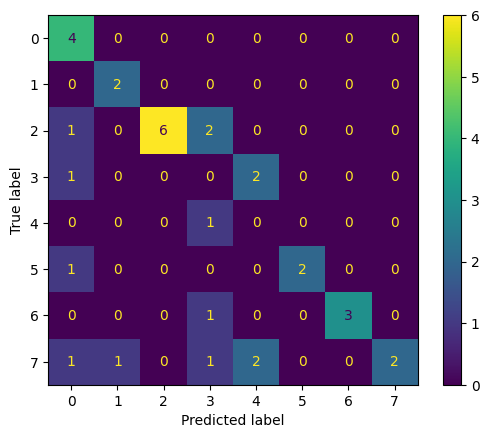

In [28]:
#Logistic Regression
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(X_train, y_train)


predictions = logistic_model.predict(X_test)
predictions_proba = logistic_model.predict_proba(X_test)


print(classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
disp.plot()
plt.show()

[[4 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 1 0 0 1 0 1]
 [0 0 1 0 0 0 3 0]
 [0 0 2 0 0 1 0 4]]


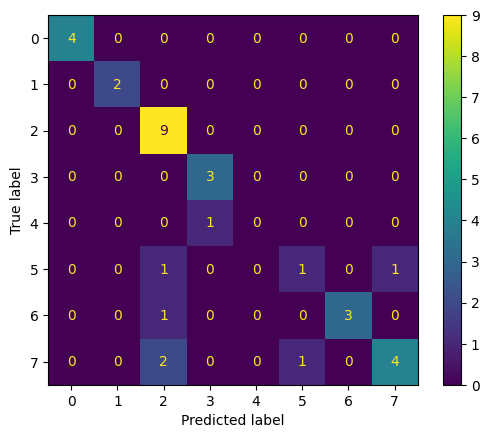

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       0.69      1.00      0.82         9
           3       0.75      1.00      0.86         3
           4       0.00      0.00      0.00         1
           5       0.50      0.33      0.40         3
           6       1.00      0.75      0.86         4
           7       0.80      0.57      0.67         7

    accuracy                           0.79        33
   macro avg       0.72      0.71      0.70        33
weighted avg       0.78      0.79      0.76        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.preprocessing import LabelEncoder
#XGBOOST
encoder_s2 = LabelEncoder()

y_train_s2_encoded = encoder_s2.fit_transform(y_train_s2)
y_test_s2_encoded = encoder_s2.transform(y_test_s2)

xgb_model_s2 = XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss'
)
xgb_model_s2.fit(X_train_s2, y_train_s2_encoded)

predictions_xgb_s2 = xgb_model_s2.predict(X_test_s2)
predictions_proba_xgb_s2 = xgb_model_s2.predict_proba(X_test_s2)

print(confusion_matrix(y_test_s2_encoded, predictions_xgb_s2))
ConfusionMatrixDisplay.from_predictions(y_test_s2_encoded, predictions_xgb_s2)
plt.show()

print(classification_report(y_test_s2_encoded, predictions_xgb_s2))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

  bottom_collision       1.00      1.00      1.00         4
bottom_obstruction       1.00      1.00      1.00         2
         collision       0.75      1.00      0.86         9
 collision_in_part       0.75      1.00      0.86         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       1.00      0.67      0.80         3
            normal       1.00      0.75      0.86         4
       obstruction       0.83      0.71      0.77         7

          accuracy                           0.85        33
         macro avg       0.79      0.77      0.77        33
      weighted avg       0.84      0.85      0.83        33



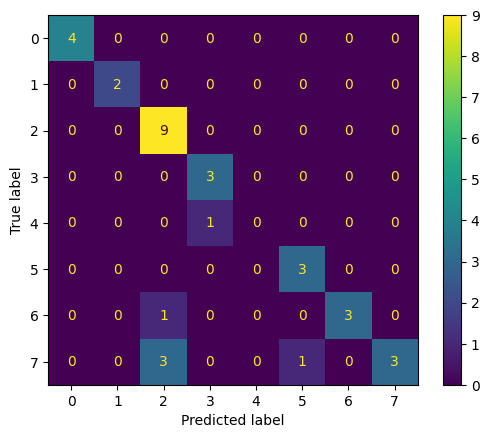

In [84]:
#Random Forest Classifier
clf_s2 = RandomForestClassifier(class_weight="balanced",random_state=200).fit(X_train_s2, y_train_s2)
predictions_rf_s2 = clf_s2.predict(X_test_s2)
predictions_proba_rf_s2 = clf_s2.predict_proba(X_test_s2)

print(classification_report(y_test_s2, predictions_rf_s2))

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

  bottom_collision       1.00      0.50      0.67         4
bottom_obstruction       0.50      1.00      0.67         2
         collision       0.62      0.89      0.73         9
 collision_in_part       0.50      0.33      0.40         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       0.40      0.67      0.50         3
            normal       0.50      0.25      0.33         4
       obstruction       0.80      0.57      0.67         7

          accuracy                           0.61        33
         macro avg       0.54      0.53      0.50        33
      weighted avg       0.63      0.61      0.58        33

Accuracy: 0.6060606060606061


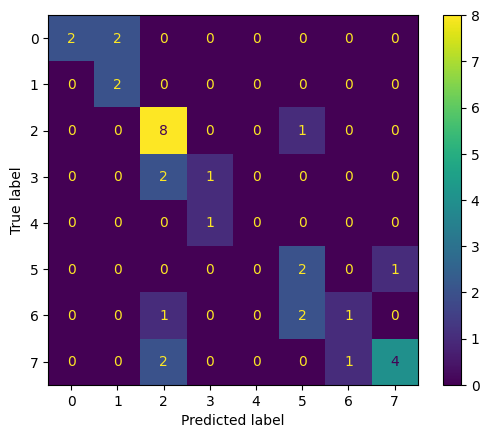

In [ ]:
#DecisionTree
clf_s2 = DecisionTreeClassifier()
clf_s2.fit(X_train_s2, y_train_s2)

y_pred_s2 = clf_s2.predict(X_test_s2)
predictions_proba_s2 = clf_s2.predict_proba(X_test_s2)

print(classification_report(y_test_s2, y_pred_s2))
print("Accuracy:", metrics.accuracy_score(y_test_s2, y_pred_s2))

cm_s2 = confusion_matrix(y_test_s2, y_pred_s2)
disp_s2 = ConfusionMatrixDisplay(confusion_matrix=cm_s2)
disp_s2.plot()
plt.show()

In [85]:
##SUMMARY FEATURES
#define the 5 sub-intervals for each 15-row sample
intervals = [(0, 3), (3, 6), (6, 9), (9, 12), (12, 15)]

feature_columns = [col for col in df_data.columns if col not in ['class_label', 'sample_num']]

list_rows = []

#group data by sample number
for sample_num, group in df_data.groupby('sample_num'):
    row_dict = {}

    for col in feature_columns:
        for i, (start, end) in enumerate(intervals, 1):
            sub_vals = group[col].iloc[start:end]
            row_dict[f'{col}_mean_int{i}'] = sub_vals.mean()
            row_dict[f'{col}_std_int{i}'] = sub_vals.std()

        row_dict[f'{col}_mean_all'] = group[col].mean()
        row_dict[f'{col}_std_all'] = group[col].std()

    # create class label
    row_dict['class_label'] = group['class_label'].iloc[0]
    list_rows.append(row_dict)

summary_df = pd.DataFrame(list_rows)

summary_df.head()



,fx_mean_int1,fx_std_int1,fx_mean_int2,fx_std_int2,fx_mean_int3,fx_std_int3,fx_mean_int4,fx_std_int4,fx_mean_int5,fx_std_int5,fx_mean_all,fx_std_all,fy_mean_int1,fy_std_int1,fy_mean_int2,fy_std_int2,fy_mean_int3,fy_std_int3,fy_mean_int4,fy_std_int4,fy_mean_int5,fy_std_int5,fy_mean_all,fy_std_all,fz_mean_int1,fz_std_int1,fz_mean_int2,fz_std_int2,fz_mean_int3,fz_std_int3,fz_mean_int4,fz_std_int4,fz_mean_int5,fz_std_int5,fz_mean_all,fz_std_all,tx_mean_int1,tx_std_int1,tx_mean_int2,tx_std_int2,tx_mean_int3,tx_std_int3,tx_mean_int4,tx_std_int4,tx_mean_int5,tx_std_int5,tx_mean_all,tx_std_all,ty_mean_int1,ty_std_int1,ty_mean_int2,ty_std_int2,ty_mean_int3,ty_std_int3,ty_mean_int4,ty_std_int4,ty_mean_int5,ty_std_int5,ty_mean_all,ty_std_all,tz_mean_int1,tz_std_int1,tz_mean_int2,tz_std_int2,tz_mean_int3,tz_std_int3,tz_mean_int4,tz_std_int4,tz_mean_int5,tz_std_int5,tz_mean_all,tz_std_all,class_label
0,-0.666667,0.577350,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.00000,-1.826667,0.760038,-0.666667,0.577350,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-0.666667,0.577350,-0.480000,1.094952,62.000000,1.000000,63.000000,0.000000,63.000000,0.000000,62.000000,1.732051,62.666667,2.309401,64.106667,23.634362,-3.000000,0.000000,-2.666667,0.577350,-3.000000,0.000000,-3.000000,0.000000,-2.666667,0.577350,0.546667,2.672651,-0.666667,0.577350,-1.0,0.000000,-0.666667,0.577350,-0.333333,0.577350,-0.666667,0.577350,-3.813333,2.064457,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,-0.013333,0.506534,normal
1,-1.000000,0.000000,-1.000000,1.732051,-0.333333,0.577350,-1.333333,1.527525,-0.666667,0.57735,0.120000,8.986416,-1.000000,0.000000,-0.666667,3.511885,-0.666667,3.214550,-0.333333,3.055050,-0.666667,1.527525,-1.013333,4.808476,62.333333,1.154701,59.666667,3.055050,61.333333,8.504901,63.333333,4.618802,64.000000,4.358899,64.186667,23.367044,-2.666667,0.577350,-3.000000,4.582576,-3.666667,5.507571,-4.333333,5.507571,-4.000000,1.732051,0.613333,9.083536,-0.666667,0.577350,-1.0,1.732051,-1.333333,1.154701,-1.000000,4.582576,-2.666667,1.527525,-2.920000,12.189672,0.000000,0.00000,-0.666667,0.57735,-0.333333,0.57735,0.000000,0.00000,-0.333333,0.57735,-0.346667,2.859282,normal
2,-0.666667,0.577350,-0.666667,0.577350,-0.666667,0.577350,-0.333333,1.154701,-1.000000,0.00000,-2.333333,2.158161,-0.666667,2.081666,-1.000000,1.000000,-1.000000,2.000000,0.000000,2.645751,0.000000,0.000000,-0.653333,4.575178,57.000000,6.000000,64.666667,3.511885,59.000000,2.000000,65.000000,1.000000,60.000000,5.567764,63.880000,22.726315,-3.333333,2.081666,-4.333333,2.081666,-2.333333,4.725816,-5.000000,3.464102,-5.000000,1.000000,-0.600000,9.828255,-1.333333,1.527525,-1.0,1.732051,-2.666667,2.309401,-1.333333,2.081666,-3.333333,1.527525,-7.613333,5.816782,-0.333333,0.57735,0.000000,0.00000,-0.333333,0.57735,-0.333333,0.57735,-0.333333,0.57735,-1.213333,4.133885,normal
3,-0.666667,1.154701,-0.333333,1.154701,0.000000,1.732051,-0.666667,0.577350,-0.333333,0.57735,-2.066667,2.521975,-1.000000,2.000000,-0.666667,2.081666,1.666667,3.055050,1.333333,0.577350,-0.666667,1.527525,-1.746667,5.385399,58.666667,2.516611,62.000000,2.000000,62.000000,5.291503,64.000000,6.000000,64.333333,2.309401,64.973333,24.451813,-3.000000,2.645751,-5.666667,4.163332,-8.000000,6.082763,-8.333333,0.577350,-6.000000,2.000000,-1.173333,9.748698,-0.666667,2.516611,0.0,4.582576,0.000000,2.000000,-4.000000,2.000000,-0.666667,1.154701,-9.453333,7.265791,-0.333333,0.57735,-0.666667,0.57735,0.333333,0.57735,-0.666667,0.57735,-0.333333,0.57735,-3.720000,4.326412,normal
4,-0.333333,0.577350,-1.333333,0.577350,0.333333,1.527525,-0.666667,0.577350,-1.000000,0.00000,-1.706667,2.431623,-1.333333,1.154701,0.000000,2.645751,0.333333,2.081666,-0.666667,2.516611,0.333333,0.577350,-1.466667,5.099903,59.666667,4.725816,59.333333,4.932883,61.000000,5.567764,65.333333,6.806859,57.666667,1.154701,63.346667,23.611434,-6.000000,2.645751,-7.333333,4.041452,-6.6666

In [86]:
cols_feat = [col for col in summary_df.columns if col != 'class_label']
cols_label = 'class_label'

X = summary_df[cols_feat]
y = summary_df[cols_label]

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

#standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split into training and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

Features shape: (164, 72)
Labels shape: (164,)


Logistic Regression (Summary Features) Classification Report:
                    precision    recall  f1-score   support

  bottom_collision       0.40      0.50      0.44         4
bottom_obstruction       1.00      0.50      0.67         2
         collision       0.42      0.56      0.48         9
 collision_in_part       0.25      0.33      0.29         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       0.50      0.67      0.57         3
            normal       1.00      0.75      0.86         4
       obstruction       1.00      0.57      0.73         7

          accuracy                           0.55        33
         macro avg       0.57      0.48      0.50        33
      weighted avg       0.62      0.55      0.56        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


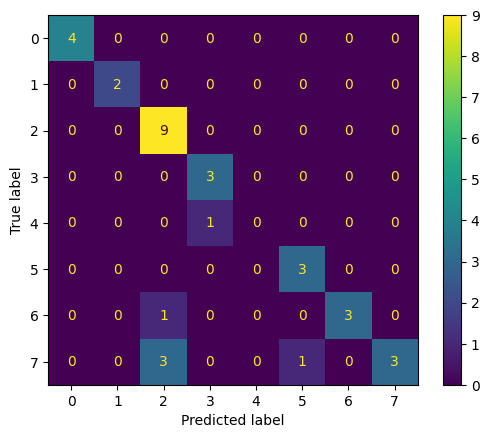

In [87]:
#Logisitc Regression
logistic_model = LogisticRegression(max_iter=10000).fit(X_train, y_train)
predictions_lr = logistic_model.predict(X_test)
predictions_proba_lr = logistic_model.predict_proba(X_test)

print("Logistic Regression (Summary Features) Classification Report:")
print(classification_report(y_test, predictions_lr))

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


XGBoost (Summary Features) Classification Report:
[[2 0 2 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [3 0 6 0 0 0 0 0]
 [0 0 1 1 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 4 0]
 [0 1 0 0 0 0 0 6]]


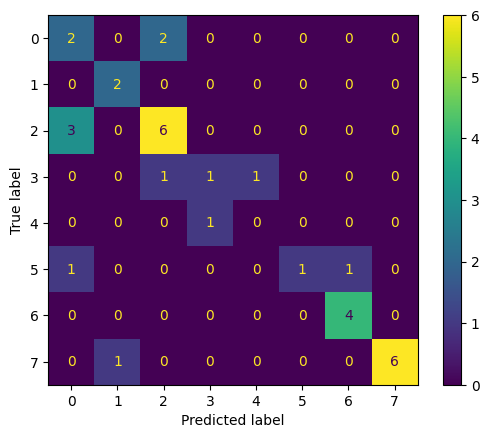

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.67      1.00      0.80         2
           2       0.67      0.67      0.67         9
           3       0.50      0.33      0.40         3
           4       0.00      0.00      0.00         1
           5       1.00      0.33      0.50         3
           6       0.80      1.00      0.89         4
           7       1.00      0.86      0.92         7

    accuracy                           0.67        33
   macro avg       0.62      0.59      0.57        33
weighted avg       0.71      0.67      0.66        33



In [88]:
from sklearn.preprocessing import LabelEncoder
#XGBOOST
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train_encoded)

predictions_xgb = xgb_model.predict(X_test)
predictions_proba_xgb = xgb_model.predict_proba(X_test)

print("XGBoost (Summary Features) Classification Report:")
print(confusion_matrix(y_test_encoded, predictions_xgb))
ConfusionMatrixDisplay.from_predictions(y_test_encoded, predictions_xgb)
plt.show()

print(classification_report(y_test_encoded, predictions_xgb))


Random Forest (Summary Features) Classification Report:
                    precision    recall  f1-score   support

  bottom_collision       0.40      0.50      0.44         4
bottom_obstruction       1.00      1.00      1.00         2
         collision       0.60      0.67      0.63         9
 collision_in_part       0.50      0.33      0.40         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       1.00      1.00      1.00         3
            normal       1.00      1.00      1.00         4
       obstruction       1.00      1.00      1.00         7

          accuracy                           0.76        33
         macro avg       0.69      0.69      0.68        33
      weighted avg       0.74      0.76      0.75        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


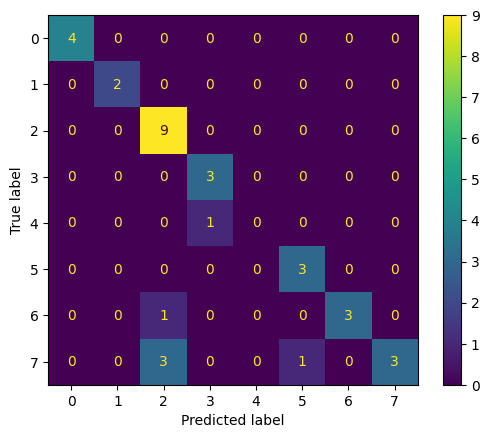

In [95]:
#Random Forest
rf_model = RandomForestClassifier(class_weight="balanced",random_state=20).fit(X_train, y_train)
predictions_rf = rf_model.predict(X_test)
predictions_proba_rf = rf_model.predict_proba(X_test)

print("Random Forest (Summary Features) Classification Report:")
print(classification_report(y_test, predictions_rf))

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

  bottom_collision       0.00      0.00      0.00         4
bottom_obstruction       0.00      0.00      0.00         2
         collision       1.00      0.78      0.88         9
 collision_in_part       0.50      0.33      0.40         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       0.50      0.67      0.57         3
            normal       0.60      0.75      0.67         4
       obstruction       0.33      0.43      0.38         7

          accuracy                           0.48        33
         macro avg       0.37      0.37      0.36        33
      weighted avg       0.51      0.48      0.49        33

Accuracy: 0.48484848484848486


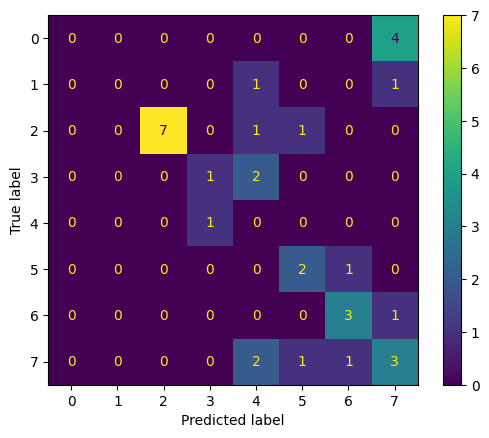

In [ ]:
#DecisionTree
clf_s2 = DecisionTreeClassifier()
clf_s2.fit(X_train_s2, y_train_s2)

y_pred_s2 = clf_s2.predict(X_test_s2)
predictions_proba_s2 = clf_s2.predict_proba(X_test_s2)

print(classification_report(y_test_s2, y_pred_s2))
print("Accuracy:", metrics.accuracy_score(y_test_s2, y_pred_s2))

cm_s2 = confusion_matrix(y_test_s2, y_pred_s2)
disp_s2 = ConfusionMatrixDisplay(confusion_matrix=cm_s2)
disp_s2.plot()
plt.show()

In [96]:
# FOURIER FEATURES

time_series_columns = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']

fourier_feature_list = []
num_fft_components = None

# Iterate over each sample
for sample_num, group in df_data.groupby('sample_num'):
    sample_features = []

    for col in time_series_columns:
        #extracts the time-series data (15 values per sample)
        ts = group[col].values

        fft_coeffs = np.fft.rfft(ts)

        fft_magnitude = np.abs(fft_coeffs)

        if num_fft_components is None:
            num_fft_components = len(fft_magnitude)

        sample_features.extend(fft_magnitude)

    fourier_feature_list.append(sample_features)

feature_columns = []
for col in time_series_columns:
    for i in range(num_fft_components):
        feature_columns.append(f"{col}_fft_{i}")

# convert to DataFrame
df_fourier = pd.DataFrame(fourier_feature_list, columns=feature_columns)

#add labels (same as previous methods)
df_fourier['class_label'] = df_data.groupby('sample_num')['class_label'].first().values

df_fourier.head()


,fx_fft_0,fx_fft_1,fx_fft_2,fx_fft_3,fx_fft_4,fx_fft_5,fx_fft_6,fx_fft_7,fx_fft_8,fx_fft_9,fx_fft_10,fx_fft_11,fx_fft_12,fx_fft_13,fx_fft_14,fx_fft_15,fx_fft_16,fx_fft_17,fx_fft_18,fx_fft_19,fx_fft_20,fx_fft_21,fx_fft_22,fx_fft_23,fx_fft_24,fx_fft_25,fx_fft_26,fx_fft_27,fx_fft_28,fx_fft_29,fx_fft_30,fx_fft_31,fx_fft_32,fx_fft_33,fx_fft_34,fx_fft_35,fx_fft_36,fx_fft_37,fy_fft_0,fy_fft_1,fy_fft_2,fy_fft_3,fy_fft_4,fy_fft_5,fy_fft_6,fy_fft_7,fy_fft_8,fy_fft_9,fy_fft_10,fy_fft_11,fy_fft_12,fy_fft_13,fy_fft_14,fy_fft_15,fy_fft_16,fy_fft_17,fy_fft_18,fy_fft_19,fy_fft_20,fy_fft_21,fy_fft_22,fy_fft_23,fy_fft_24,fy_fft_25,fy_fft_26,fy_fft_27,fy_fft_28,fy_fft_29,fy_fft_30,fy_fft_31,fy_fft_32,fy_fft_33,fy_fft_34,fy_fft_35,fy_fft_36,fy_fft_37,fz_fft_0,fz_fft_1,fz_fft_2,fz_fft_3,fz_fft_4,fz_fft_5,fz_fft_6,fz_fft_7,fz_fft_8,fz_fft_9,fz_fft_10,fz_fft_11,fz_fft_12,fz_fft_13,fz_fft_14,fz_fft_15,fz_fft_16,fz_fft_17,fz_fft_18,fz_fft_19,fz_fft_20,fz_fft_21,fz_fft_22,fz_fft_23,fz_fft_24,fz_fft_25,fz_fft_26,fz_fft_27,fz_fft_28,fz_fft_29,fz_fft_30,fz_fft_31,fz_fft_32,fz_fft_33,fz_fft_34,fz_fft_35,fz_fft_36,fz_fft_37,tx_fft_0,tx_fft_1,tx_fft_2,tx_fft_3,tx_fft_4,tx_fft_5,tx_fft_6,tx_fft_7,tx_fft_8,tx_fft_9,tx_fft_10,tx_fft_11,tx_fft_12,tx_fft_13,tx_fft_14,tx_fft_15,tx_fft_16,tx_fft_17,tx_fft_18,tx_fft_19,tx_fft_20,tx_fft_21,tx_fft_22,tx_fft_23,tx_fft_24,tx_fft_25,tx_fft_26,tx_fft_27,tx_fft_28,tx_fft_29,tx_fft_30,tx_fft_31,tx_fft_32,tx_fft_33,tx_fft_34,tx_fft_35,tx_fft_36,tx_fft_37,ty_fft_0,ty_fft_1,ty_fft_2,ty_fft_3,ty_fft_4,ty_fft_5,ty_fft_6,ty_fft_7,ty_fft_8,ty_fft_9,ty_fft_10,ty_fft_11,ty_fft_12,ty_fft_13,ty_fft_14,ty_fft_15,ty_fft_16,ty_fft_17,ty_fft_18,ty_fft_19,ty_fft_20,ty_fft_21,ty_fft_22,ty_fft_23,ty_fft_24,ty_fft_25,ty_fft_26,ty_fft_27,ty_fft_28,ty_fft_29,ty_fft_30,ty_fft_31,ty_fft_32,ty_fft_33,ty_fft_34,ty_fft_35,ty_fft_36,ty_fft_37,tz_fft_0,tz_fft_1,tz_fft_2,tz_fft_3,tz_fft_4,tz_fft_5,tz_fft_6,tz_fft_7,tz_fft_8,tz_fft_9,tz_fft_10,tz_fft_11,tz_fft_12,tz_fft_13,tz_fft_14,tz_fft_15,tz_fft_16,tz_fft_17,tz_fft_18,tz_fft_19,tz_fft_20,tz_fft_21,tz_fft_22,tz_fft_23,tz_fft_24,tz_fft_25,tz_fft_26,tz_fft_27,tz_fft_28,tz_fft_29,tz_fft_30,tz_fft_31,tz_fft_32,tz_fft_33,tz_fft_34,tz_fft_35,tz_fft_36,tz_fft_37,class_label
0,137.0,16.325019,10.093940,9.809399,7.403183,6.633858,2.319324,7.240103,8.940927,3.481327,1.857234,1.942930,7.204166,6.812084,3.081020,6.657795,3.003492,9.741275,9.210181,3.516700,3.004391,7.148481,8.271937,4.633049,6.485784,3.605551,4.945436,5.122197,7.075134,6.454410,5.354789,5.366577,6.367183,5.211901,4.037626,4.529486,2.825309,3.432063,36.0,33.322519,28.948499,19.761654,11.103069,1.826749,2.349270,6.445217,4.970532,2.629556,2.555151,2.699679,7.764307,4.993179,5.544858,4.429225,3.986659,0.746733,3.957017,5.275439,6.175364,6.066595,6.871111,4.320669,1.552487,4.582576,7.236818,8.740718,5.934708,2.803983,4.169169,6.179861,7.856565,6.742595,6.937237,5.098928,0.156243,0.667541,4808.0,669.193089,774.127930,532.975304,193.863754,42.587633,73.833298,205.435255,173.424800,86.386611,47.122087,54.753008,104.054360,95.565914,26.527170,12.008398,58.299543,115.023529,103.669873,46.486447,17.857587,38.009890,70.032714,79.757887,27.662005,9.848858,40.762259,70.712591,87.025910,38.720378,12.992243,11.217962,51.786636,60.163337,33.232330,13.598128,12.195680,33.115039,41.0,105.417348,53.864056,37.453815,25.254034,3.442195,17.536485,19.309820,10.885579,12.334636,8.246770,16.332503,19.142436,16.426570,18.100370,11.473991,10.538867,5.056455,14.820592,13.767588,5.867703,2.324467,1.621435,8.414270,6.949769,12.767145,2.448759,4.792266,4.865177,9.116614,10.017361,6.207372,6.220361,4.098171,1.656329,8.228739,8.543658,5.491004,286.0,67.841730,35.984407,29.828898,19.607700,5.480663,10.417436,5.832932,18.363013,12.606891,9.961365,6.293244,9.394308,14.109318,9.980654,16.953748,11.331407,21.393663,12.457981,9.763104,19.560126,8.532775,12.425662,8.461403,6.349151,12.529964,13.449297,14.336294,11.781126,12.619750,13.585670,15.267204,8.916571,8.512266,10.720559,6.0112

In [97]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
numeric_cols_fourier = df_fourier.columns.difference(['class_label'])

df_fourier[numeric_cols_fourier] = imputer.fit_transform(df_fourier[numeric_cols_fourier])

null_percentages_fourier = df_fourier.isnull().sum() / df_fourier.shape[0] * 100
df_fourier.isnull().sum().any()


False

In [98]:
# separate features and label
cols_feat_fourier = [col for col in df_fourier.columns if col != 'class_label']
X_fourier = df_fourier[cols_feat_fourier]
y_fourier = df_fourier['class_label']


scaler = StandardScaler()
X_fourier_scaled = scaler.fit_transform(X_fourier)

# split the data into training and test sets
X_train_fourier, X_test_fourier, y_train_fourier, y_test_fourier = train_test_split(
    X_fourier_scaled, y_fourier, test_size=0.2, random_state=42, stratify=y_fourier
)



Logistic Regression (Fourier Features) Classification Report:
                    precision    recall  f1-score   support

  bottom_collision       0.80      1.00      0.89         4
bottom_obstruction       1.00      1.00      1.00         2
         collision       0.90      1.00      0.95         9
 collision_in_part       1.00      1.00      1.00         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       0.50      0.67      0.57         3
            normal       1.00      0.75      0.86         4
       obstruction       0.83      0.71      0.77         7

          accuracy                           0.85        33
         macro avg       0.75      0.77      0.75        33
      weighted avg       0.84      0.85      0.84        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


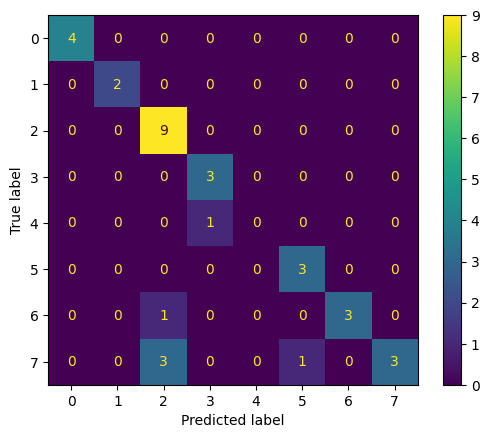

In [99]:
#Logistic Regression
logistic_model_fourier = LogisticRegression(max_iter=10000).fit(X_train_fourier, y_train_fourier)
predictions_lr_fourier = logistic_model_fourier.predict(X_test_fourier)
predictions_proba_lr_fourier = logistic_model_fourier.predict_proba(X_test_fourier)

print("Logistic Regression (Fourier Features) Classification Report:")
print(classification_report(y_test_fourier, predictions_lr_fourier))

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

XGBoost (Fourier Features) Classification Report:
[[4 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0]
 [1 0 0 2 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 2 0 1]
 [0 0 1 0 0 0 3 0]
 [0 0 0 0 0 3 0 4]]


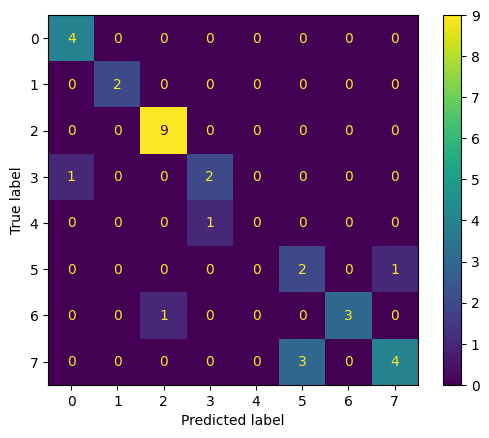

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         2
           2       0.90      1.00      0.95         9
           3       0.67      0.67      0.67         3
           4       0.00      0.00      0.00         1
           5       0.40      0.67      0.50         3
           6       1.00      0.75      0.86         4
           7       0.80      0.57      0.67         7

    accuracy                           0.79        33
   macro avg       0.70      0.71      0.69        33
weighted avg       0.79      0.79      0.78        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [100]:
#XGBOOST
from sklearn.preprocessing import LabelEncoder

encoder_fourier = LabelEncoder()
# Encode labels for XGBoost
y_train_fourier_encoded = encoder_fourier.fit_transform(y_train_fourier)
y_test_fourier_encoded = encoder_fourier.transform(y_test_fourier)

xgb_model_fourier = XGBClassifier(
    objective='multi:softprob',
    num_class=5,  # assuming 5 classes
    eval_metric='mlogloss'
)
xgb_model_fourier.fit(X_train_fourier, y_train_fourier_encoded)

predictions_xgb_fourier = xgb_model_fourier.predict(X_test_fourier)
predictions_proba_xgb_fourier = xgb_model_fourier.predict_proba(X_test_fourier)

print("XGBoost (Fourier Features) Classification Report:")
print(confusion_matrix(y_test_fourier_encoded, predictions_xgb_fourier))
ConfusionMatrixDisplay.from_predictions(y_test_fourier_encoded, predictions_xgb_fourier)
plt.show()

print(classification_report(y_test_fourier_encoded, predictions_xgb_fourier))

Random Forest (Fourier Features) Classification Report:
                    precision    recall  f1-score   support

  bottom_collision       0.80      1.00      0.89         4
bottom_obstruction       1.00      1.00      1.00         2
         collision       0.90      1.00      0.95         9
 collision_in_part       0.67      0.67      0.67         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       0.67      0.67      0.67         3
            normal       1.00      0.75      0.86         4
       obstruction       0.86      0.86      0.86         7

          accuracy                           0.85        33
         macro avg       0.74      0.74      0.74        33
      weighted avg       0.83      0.85      0.83        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


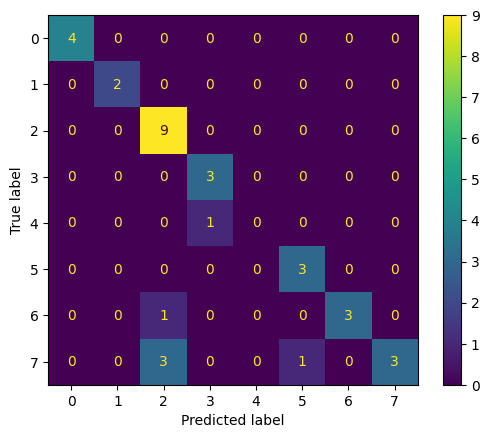

In [106]:
#Random Forest Classifier
rf_model_fourier = RandomForestClassifier(class_weight="balanced",random_state=20000).fit(X_train_fourier, y_train_fourier)
predictions_rf_fourier = rf_model_fourier.predict(X_test_fourier)
predictions_proba_rf_fourier = rf_model_fourier.predict_proba(X_test_fourier)

print("Random Forest (Fourier Features) Classification Report:")
print(classification_report(y_test_fourier, predictions_rf_fourier))

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

  bottom_collision       0.57      1.00      0.73         4
bottom_obstruction       1.00      1.00      1.00         2
         collision       0.58      0.78      0.67         9
 collision_in_part       0.75      1.00      0.86         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       0.00      0.00      0.00         3
            normal       0.50      0.25      0.33         4
       obstruction       0.60      0.43      0.50         7

          accuracy                           0.61        33
         macro avg       0.50      0.56      0.51        33
      weighted avg       0.55      0.61      0.55        33

Accuracy: 0.6060606060606061


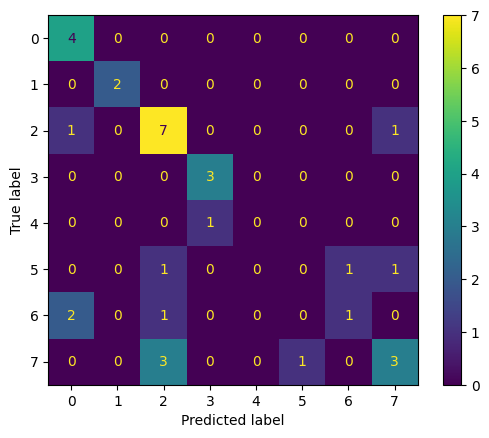

In [ ]:
#DecisionTree
clf_s2 = DecisionTreeClassifier()
clf_s2.fit(X_train_s2, y_train_s2)

y_pred_s2 = clf_s2.predict(X_test_s2)
predictions_proba_s2 = clf_s2.predict_proba(X_test_s2)

print(classification_report(y_test_s2, y_pred_s2))
print("Accuracy:", metrics.accuracy_score(y_test_s2, y_pred_s2))

cm_s2 = confusion_matrix(y_test_s2, y_pred_s2)
disp_s2 = ConfusionMatrixDisplay(confusion_matrix=cm_s2)
disp_s2.plot()
plt.show()

In [135]:
#ALL METHODS

df_data_ren = df_data.copy()
df_data_ren.rename(columns={'class_label': 'label'}, inplace=True)

def flatten_forces(group):
    arr = group.drop(columns=['label', 'sample_num']).to_numpy().flatten()
    return pd.DataFrame([arr])

df_forces_flat = (
    df_data_ren.groupby('sample_num', group_keys=False)
               .apply(flatten_forces)
               .reset_index(drop=True)
)

df_forces_flat['label'] = df_data_ren.groupby('sample_num')['label'].first().values

combined_df = pd.concat([
    df_features.drop(columns='label', errors='ignore').reset_index(drop=True),
    df_forces_flat.drop(columns='label', errors='ignore').reset_index(drop=True),
    summary_df.drop(columns=[col for col in summary_df.columns if 'label' in col], errors='ignore').reset_index(drop=True),
    df_fourier.drop(columns='label', errors='ignore').reset_index(drop=True)
], axis=1)

combined_df['label'] = df_features['label'].reset_index(drop=True)

combined_df.head()




<ipython-input-135-a7c0a28acf9b>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(flatten_forces)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,fx_mean_int1,fx_std_int1,fx_mean_int2,fx_std_int2,fx_mean_int3,fx_std_int3,fx_mean_int4,fx_std_int4,fx_mean_int5,fx_std_int5,fx_mean_all,fx_std_all,fy_mean_int1,fy_std_int1,fy_mean_int2,fy_std_int2,fy_mean_int3,fy_std_int3,fy_mean_int4,fy_std_int4,fy_mean_int5,fy_std_int5,fy_mean_all,fy_std_all,fz_mean_int1,fz_std_int1,fz_mean_int2,fz_std_int2,fz_mean_int3,fz_std_int3,fz_mean_int4,fz_std_int4,fz_mean_int5,fz_std_int5,fz_mean_all,fz_std_all,tx_mean_int1,tx_std_int1,tx_mean_int2,tx_std_int2,tx_mean_int3,tx_std_int3,tx_mean_int4,tx_std_int4,tx_mean_int5,tx_std_int5,tx_mean_all,tx_std_all,ty_mean_int1,ty_std_int1,ty

In [136]:
#convert integer column names to strings in each relevant DataFrame
for df_ in [df_features, df_forces_flat, summary_df, df_fourier, combined_df]:
    df_.columns = df_.columns.map(str)


In [137]:
cols_feat_combined = [col for col in combined_df.columns if col != 'label']
X_combined = combined_df[cols_feat_combined].select_dtypes(include=[np.number])
y_combined = combined_df['label']

print("Features shape:", X_combined.shape)
print("Labels shape:  ", y_combined.shape)

scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined.fillna(0))

X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined_scaled, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)


Features shape: (164, 2100)
Labels shape:   (164,)


Logistic Regression (All Methods) Classification Report:
                    precision    recall  f1-score   support

  bottom_collision       0.57      1.00      0.73         4
bottom_obstruction       1.00      0.50      0.67         2
         collision       0.82      1.00      0.90         9
 collision_in_part       0.00      0.00      0.00         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       0.67      0.67      0.67         3
            normal       1.00      0.75      0.86         4
       obstruction       0.67      0.29      0.40         7

          accuracy                           0.64        33
         macro avg       0.59      0.53      0.53        33
      weighted avg       0.68      0.64      0.62        33



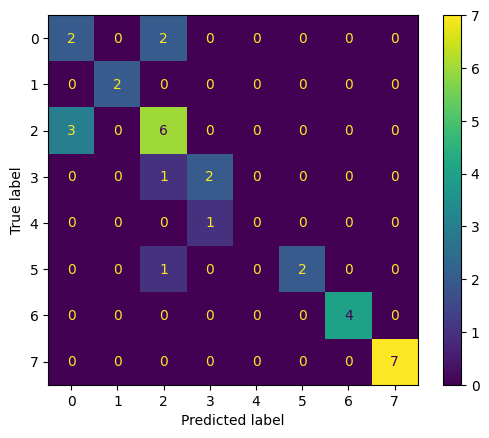

In [138]:
# Logistic Regression
logistic_model_combined = LogisticRegression(max_iter=10000)
logistic_model_combined.fit(X_train_combined, y_train_combined)

predictions_lr_combined = logistic_model_combined.predict(X_test_combined)
predictions_proba_lr_combined = logistic_model_combined.predict_proba(X_test_combined)

print("Logistic Regression (All Methods) Classification Report:")
print(classification_report(y_test_combined, predictions_lr_combined))

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


XGBoost (Combined Features) Classification Report:
[[4 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0]
 [0 0 0 2 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 2]
 [0 0 1 0 0 0 3 0]
 [0 0 1 0 0 1 0 5]]


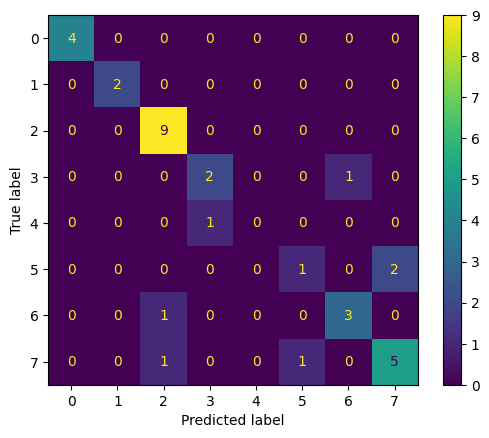

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       0.82      1.00      0.90         9
           3       0.67      0.67      0.67         3
           4       0.00      0.00      0.00         1
           5       0.50      0.33      0.40         3
           6       0.75      0.75      0.75         4
           7       0.71      0.71      0.71         7

    accuracy                           0.79        33
   macro avg       0.68      0.68      0.68        33
weighted avg       0.75      0.79      0.77        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [139]:
from sklearn.preprocessing import LabelEncoder

#XGBoost Classifier
encoder_combined = LabelEncoder()
y_train_combined_encoded = encoder_combined.fit_transform(y_train_combined)
y_test_combined_encoded = encoder_combined.transform(y_test_combined)

xgb_model_combined = XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss'
)
xgb_model_combined.fit(X_train_combined, y_train_combined_encoded)

predictions_xgb_combined = xgb_model_combined.predict(X_test_combined)
predictions_proba_xgb_combined = xgb_model_combined.predict_proba(X_test_combined)

print("XGBoost (Combined Features) Classification Report:")
print(confusion_matrix(y_test_combined_encoded, predictions_xgb_combined))
ConfusionMatrixDisplay.from_predictions(y_test_combined_encoded, predictions_xgb_combined)
plt.show()

print(classification_report(y_test_combined_encoded, predictions_xgb_combined))

Random Forest (Combined Features) Classification Report:
                    precision    recall  f1-score   support

  bottom_collision       1.00      1.00      1.00         4
bottom_obstruction       1.00      1.00      1.00         2
         collision       0.90      1.00      0.95         9
 collision_in_part       0.75      1.00      0.86         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       0.75      1.00      0.86         3
            normal       1.00      0.75      0.86         4
       obstruction       1.00      0.86      0.92         7

          accuracy                           0.91        33
         macro avg       0.80      0.83      0.81        33
      weighted avg       0.90      0.91      0.90        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


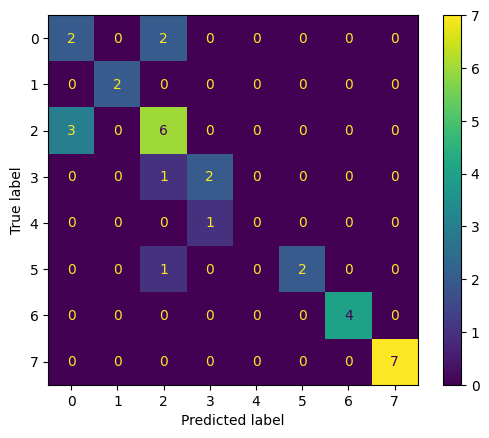

In [140]:
#Random Forest Classifier
rf_model_combined = RandomForestClassifier(class_weight="balanced",random_state=200).fit(X_train_combined, y_train_combined)
predictions_rf_combined = rf_model_combined.predict(X_test_combined)
predictions_proba_rf_combined = rf_model_combined.predict_proba(X_test_combined)

print("Random Forest (Combined Features) Classification Report:")
print(classification_report(y_test_combined, predictions_rf_combined))

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

                    precision    recall  f1-score   support

  bottom_collision       1.00      0.75      0.86         4
bottom_obstruction       1.00      1.00      1.00         2
         collision       0.67      0.67      0.67         9
 collision_in_part       0.60      1.00      0.75         3
 collision_in_tool       0.00      0.00      0.00         1
      fr_collision       1.00      0.67      0.80         3
            normal       0.60      0.75      0.67         4
       obstruction       0.50      0.43      0.46         7

          accuracy                           0.67        33
         macro avg       0.67      0.66      0.65        33
      weighted avg       0.69      0.67      0.67        33

Accuracy: 0.6666666666666666


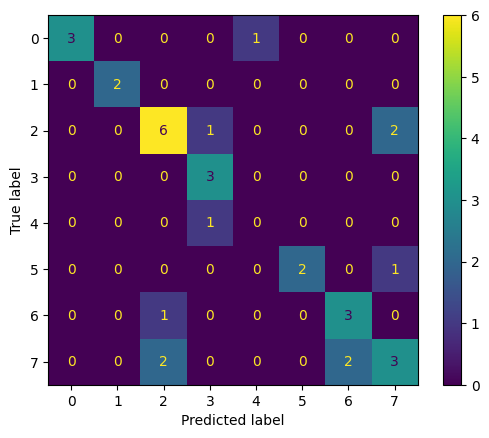

In [144]:
#DecisionTree
clf_s2 = DecisionTreeClassifier()
clf_s2.fit(X_train_s2, y_train_s2)

y_pred_s2 = clf_s2.predict(X_test_s2)
predictions_proba_s2 = clf_s2.predict_proba(X_test_s2)

print(classification_report(y_test_s2, y_pred_s2))
print("Accuracy:", metrics.accuracy_score(y_test_s2, y_pred_s2))

cm_s2 = confusion_matrix(y_test_s2, y_pred_s2)
disp_s2 = ConfusionMatrixDisplay(confusion_matrix=cm_s2)
disp_s2.plot()
plt.show()